# 傅里叶变换的更多性质

除了上一篇博文[傅里叶变换的基本性质](https://mp.csdn.net/mdeditor/84431146)所提到的性质外，傅里叶变换还有一些非常有用的性质和概念，包括：
+ 能量不变（Energy conservation）
+ 分贝幅度（Amplitude in decibels(dB)）
+ 相位展开（Phase unwrapping）
+ 补零（Zero-padding）
+ 快速傅里叶变换（FFT）
+ 零相位窗（Zero-phase windowing）

以上概念或者性质能够帮助我们更好利用傅里叶变换对信号进行分析，接下来配合具体代码逐个说明

首先导入必要的库

In [1]:
import numpy as np
from scipy.fftpack import fft
from scipy.io.wavfile import read as WAV_read
from scipy.signal import get_window
import matplotlib.pyplot as plt
%matplotlib inline

## 能量不变（Energy conservation）

即在时域上计算能量的结果与在频域上的结算结果不变，公式表达为：
$$
\sum_{n=-N/2}^{N/2 - 1}\vert x[n]^2\vert = \frac{1}{N}\sum_{k=-N/2}^{N/2 - 1} \vert X[k]^2\vert
$$

我们举个小例子来说明这个性质

下面的代码计算了一段信号在时域和频域上的信号，结果显示，它们完全一致

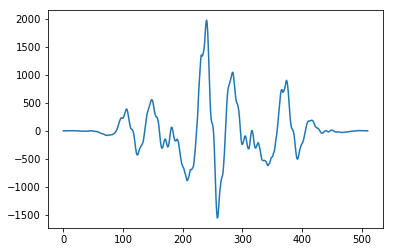

Energy in time domian : 113106768.166
Energy in frequency domian : 113106768.166


In [2]:
N = 511
audio_path = 'sounds/soprano-E4.wav'
(fs, x) = WAV_read(audio_path)
x = x[1000:1000+N]
w = get_window('blackman', N)
xw = x*w;
plt.plot(xw)
plt.show()

X = fft(xw)

# calculating energy in time domain and frequency domain
energy_in_time = np.sum(np.square(xw))
energy_in_freq = 1.0/N * np.sum(np.square(np.abs(X)))

print('Energy in time domian :', energy_in_time)
print('Energy in frequency domian :', energy_in_freq)

## 分贝幅度（Amplitude in decibels(dB)）

通过对幅度进行对数，可以得到分贝幅度。分贝幅度视觉效果更好，具体计算公式为：
$$
A = 20*\log(abs(X))
$$

其中A表示分贝幅度，X为傅里叶变换后的信号，$\log$是以10为底的对数操作

分贝幅度能够更好显示幅度的变化
![Amplitude_in_decibels](imgs/Amplitude_in_decibels.png)

下面的程序演示了分贝幅度的计算过程



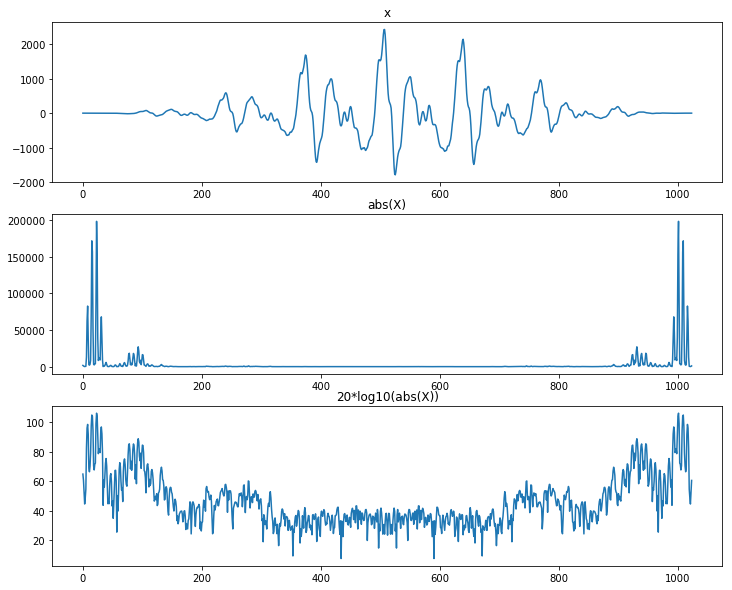

In [3]:
N = 1024
audio_path = 'sounds/soprano-E4.wav'
(fs, x) = WAV_read(audio_path)
x = x[1000:1000+N]
w = get_window('blackman', N)
xw = x*w

X = fft(xw)
abs_X = np.abs(X)
mX = 20*np.log10(abs_X)

plt.figure(figsize=(12,10))

plt.subplot(311)
plt.plot(xw);plt.title('x')

plt.subplot(312)
plt.plot(abs_X);plt.title('abs(X)')

plt.subplot(313)
plt.plot(mX);plt.title('20*log10(abs(X))')

plt.show()

## 相位展开（Phase unwrapping）

幅度可以用分贝幅度来获得更好的表示，同样的，相位能够用相位展开来优化显示效果

![Phase_unwrapping](imgs/Phase_unwrapping.png)

如果不使用相位展开，相位会严格的落在$[\pi, -\pi]$之间，这样显示的相位看起来特别乱，没有规律

关于相位展开的详细说明，请参看[Unwrap](https://www.mathworks.com/help/dsp/ref/unwrap.html?searchHighlight=phase%20unwrap&s_tid=doc_srchtitle)
根据上面这个参考链接，我们可以写一个自己的简单版本的unwrap

下面代码说明如何做相位展开以及如何写unwrap

In [88]:
def my_unwrap(p):
    discont = np.pi
    unwraped_p = np.zeros(p.size)
    unwraped_p[0] = p[0]
    count = 0
    # 遍历相位，下标从1开始
    for i in range(1, len(p)):
        diff = p[i] - p[i-1]
        if(diff > discont):
            count -= 2
        elif(diff < -discont):
            count += 2
    
        unwraped_p[i] = p[i] + count*np.pi
    return unwraped_p

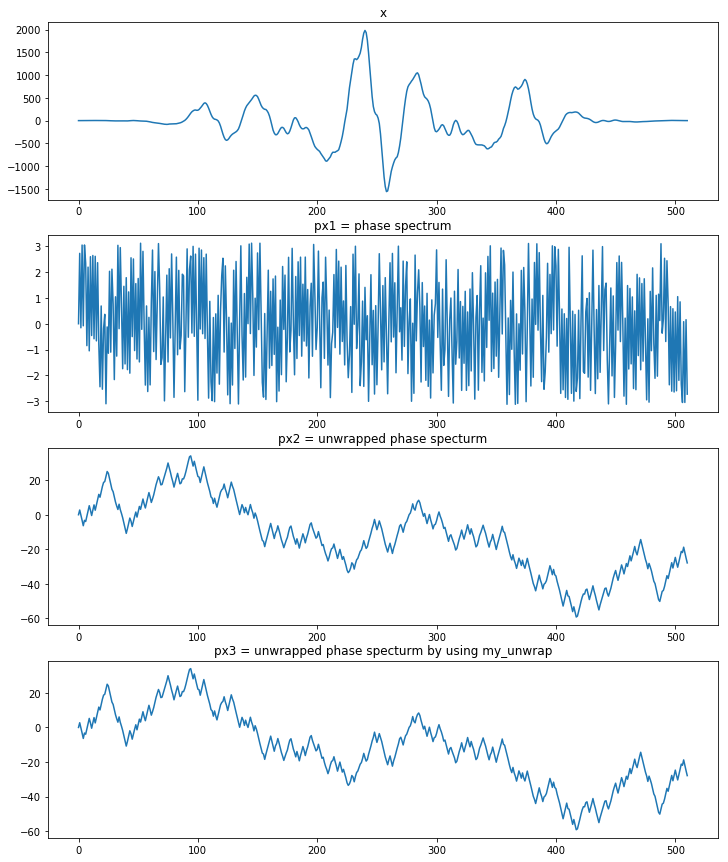

In [95]:
N = 511
audio_path = 'sounds/soprano-E4.wav'
(fs, x) = WAV_read(audio_path)
x = x[1000:1000+N]
w = get_window('blackman', N)
xw = x*w

X = fft(xw)
abs_X = np.abs(X)
mX = 20*np.log10(abs_X)
px1 = np.angle(X)
px2 = np.unwrap(px1)
px3 = my_unwrap(px1)

plt.figure(figsize=(12,15))

plt.subplot(411)
plt.plot(xw);plt.title('x')

plt.subplot(412)
plt.plot(px1);plt.title('px1 = phase spectrum')

plt.subplot(413)
plt.plot(px2);plt.title('px2 = unwrapped phase specturm')

plt.subplot(414)
plt.plot(px3);plt.title('px3 = unwrapped phase specturm by using my_unwrap')

plt.show()

## 补零（Zero-padding）

在时域信号上的尾部补零，那么等同于在频域上做插值

补零是非常有用的一个性质，它可以增加频域的分辨率

![Zero_padding](imgs/Zero_padding.png)


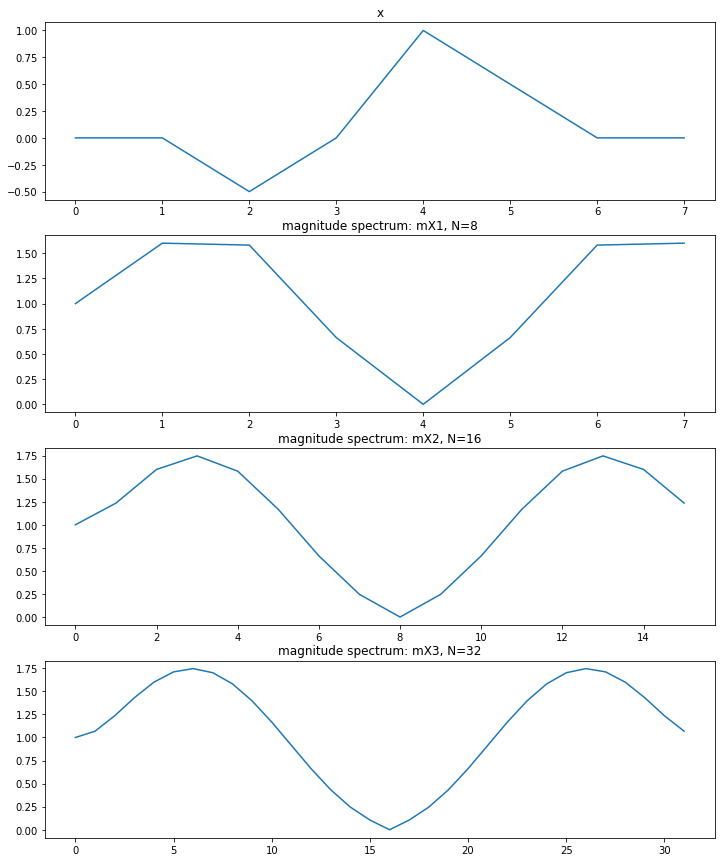

In [107]:
x = np.array([0,0,-.5,0,1,0.5,0,0])
X = fft(x)
mX1 = np.abs(X)

# 在x尾部添加了8个0
x2 = np.pad(x, (0,8), 'constant', constant_values=(0))
X2 = fft(x2)
mX2 = np.abs(X2)

# 在x1尾部添加了16个0
x3 = np.pad(x2, (0,16), 'constant', constant_values=(0))
X3 = fft(x3)
mX3 = np.abs(X3)

plt.figure(figsize=(12,15))

plt.subplot(411)
plt.plot(x);plt.title('x')

plt.subplot(412)
plt.plot(mX1);plt.title('magnitude spectrum: mX1, N=8')

plt.subplot(413)
plt.plot(mX2);plt.title('magnitude spectrum: mX2, N=16')

plt.subplot(414)
plt.plot(mX3);plt.title('magnitude spectrum: mX3, N=32')

plt.show()

## 快速傅里叶变换（FFT）

快速傅里叶变换由Cooley-Tukey提出，将傅里叶变换的计算复杂度从O(n^2)减低到O(nlogn)，但是算法要求输入数据的长度必须是2的次幂

因此，为了使用FFT，我们通常需要对输入信号进行补零至2的次幂大小

另外要说的就是Scipy中的fft，如果输入大小为2的次幂大小，那么fft做快速傅里叶变换，否则它做离散傅里叶变换

通常，在信号处理中，我们都使用FFT，因为它快啊

## 零相位窗（Zero-phase windowing）

在使用FFT时，除了要补零以外，通常还要加一个零相位窗的操作，所谓零相位就是让信号以第0个抽样点左右对称。参看[零相位,线性相位与非线性相位](https://blog.csdn.net/shawn_shao/article/details/80178552)

这么做的好处：得到的结果具有对称性，非常棒

零相位窗的操作很简单，请看下面的示意图![Zero_phase_windowing_2](imgs/Zero_phase_windowing_2.png)

配合代码，你肯定能明白零相位窗是怎么工作的

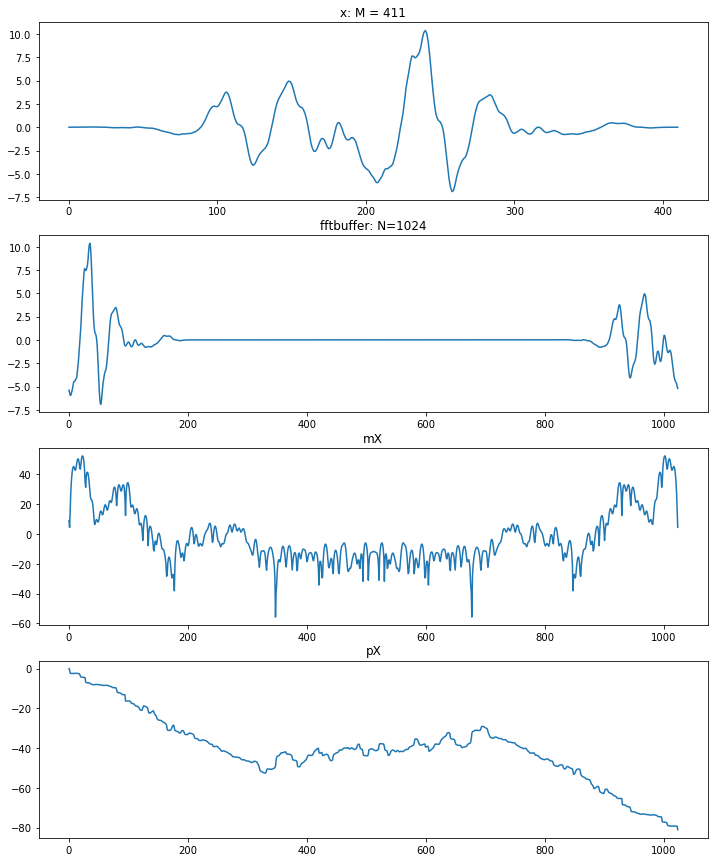

In [117]:
M = 411
audio_path = 'sounds/soprano-E4.wav'
(fs, x) = WAV_read(audio_path)
x = x[1000:1000+M]
w = get_window('blackman', M)
w = w/sum(w)
xw = x*w

N = 1024 # power of 2
fftbuffer = np.zeros(N)
hm1 = (M+1)//2
hm2 = M//2
fftbuffer[:hm1] = xw[-hm1:]
fftbuffer[-hm2:] = xw[:hm2]

X = fft(fftbuffer)
mX = 20*np.log10(np.abs(X))
pX = np.unwrap(np.angle(X))

plt.figure(figsize=(12,15))

plt.subplot(411)
plt.plot(xw);plt.title('x: M = 411')

plt.subplot(412)
plt.plot(fftbuffer);plt.title('fftbuffer: N=1024')

plt.subplot(413)
plt.plot(mX);plt.title('mX')

plt.subplot(414)
plt.plot(pX);plt.title('pX')

plt.show()

# 总结

以上我们总结了傅里叶变换常用的性质和概念，讲清楚了这些，在下一个文章中，我们就可以实现一个完整的DFT代码啦